# Numerical solver for Schroedinger's equation.
## Numpy Update

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

%matplotlib inline

rc('text', usetex=True)

In [2]:
def potential(position):
    '''
    A function used to return a potential. When u < 1.0, then potential is 0.
    When u = 1.0, then potential is 1/2. And when u > 1.0, then potential is 1
    '''
    if position < 1 / 2:
        return 0
    elif position == 1 / 2:
        return 1 / 2
    return 1

In [3]:
def shooting(initwave, initderiv, energy, x_axis):
    '''
    First function to be called when generating a new eigenfunction. Arguments are
    used to specify initial conditions, energy epsilon, and number of points
    (spacing)

    :param initwave: Initial value for the wavefunction
    :param initderiv: Initial value for the derivative
    :param energy: Value for the energy eigenvalue
    :param noofpoints: Number of points calculated
    '''
    # Initializing 3d array to store wave, derivatives, and position
    wave = np.zeros((2, x_axis.size))
    wave[0][0] = initwave
    wave[1][0] = initderiv
    # Calculate delta x based on number of points requested
    return generate(wave, x_axis, energy)

In [4]:
def generate(wave, xscale, energy):
    '''
    Function that is actually performing all the calculations for the new
    eigenfunction
    '''
    beta = 64
    delta = xscale[1] - xscale[0]

    for i in range(1, wave[0].size):
        # Equation 2 in code form
        wave[0][i] = wave[0][i - 1] + delta * wave[1][i - 1]
        # Equation 1 in code form
        wave[1][i] = wave[1][i - 1] - delta * beta * \
            (energy - potential(xscale[i - 1])) * wave[0][i - 1]

    return wave[0]

In [5]:
def areaunder(wave, x_axis, xmax=0):
    '''
    Function that returns the area under the graph of a mathematical
    function passed as an argument. The area is calculated from x=0
    to x=xmax
    '''
    if xmax == 0:
        xmax = x_axis[-1]

    # Calculating the probability distribution of the wave
    y_val = probability(wave)
    area = 0
    for i in range(0, len(y_val) - 1):
        if x_axis[i] < xmax:
            # The middle value between to y data points is used
            area += (y_val[i] + (y_val[i + 1] - y_val[i]) / 2) * \
                (x_axis[i + 1] - x_axis[i])
    area = area * 2
    print("Area " + str(area))
    return area

In [6]:
def probability(wave):
    '''
    Function returning probability distribution for a given real wave function
    '''
    return wave * wave

In [7]:
def normalization(wave, x_axis):
    '''
    Function that returns normalized wave function by calculating overall probability
    and dividing the wave function by this normalization constant
    '''
    # TODO: automate xmax
    constant = 1 / math.sqrt(areaunder(wave, x_axis, 3))
    # List comprehension is used to divide all data points by the
    # constant = 1/K from Equation 5
    return wave * constant

In [8]:
def ploteigenfcs(x_axis, lines, title, file_name='', save=False):
    '''
    Plots three different functions onto one figure. Currently the color used are
    black, blue, red, magneto, cyan, and yellow
    '''
    # Get line to plot for potential energy V(x)
    energy_function = np.vectorize(potential)
    energy_line = energy_function(x_axis)

    plt.figure()
    plt.rc('lines', linewidth=1.5)
    plt.rc('axes', prop_cycle=cycler(
        'color', ['k', 'b', 'r', 'g', 'm', 'c', 'y']))
    for desc, wave in lines.items():
        plt.plot(x_axis, wave, label=desc)

    plt.plot(x_axis, energy_line, label='potential')

    ymax = 0
    ymin = 0
    for wave in lines.values():
        ymax = np.maximum(np.amax(wave, axis=0), ymax)
        ymin = np.minimum(np.amin(wave, axis=0), ymin)
    plt.ylim(ymin-0.1, ymax+0.1)
    plt.xlim(0, 4)
    plt.xlabel(r'Radius $u=r/a_{0}$')
    plt.ylabel(r'Eigenfunction $\psi(u)$')
    plt.title(title, ha='center', fontsize=14)
    plt.legend()
    plt.grid()

    if save:
        plt.savefig('files/' + str(file_name) + '.eps', format='eps',
                    dpi=1000)  # Optional line: saves the plot as .eps file

In [9]:
def numerical_slv():
    '''
    Executes the numerical solver script and generates plots
    '''
    energy0 = 0.09799850486  # Ground state energy
    energy1 = 0.38272399  # First excited state energy
    energy2 = 0.807899  # Second excited state energy
    energy_unb = 2

    x_axis = np.linspace(0.0, 3.0, 6000)
    eigenfc = shooting(1.0, 0, energy0, x_axis)
    normalized = normalization(eigenfc, x_axis)
    lines = {
        'Ground State': normalized,
    }
    
    ploteigenfcs(x_axis, lines,
                 r'\textbf{Eigenfunctions vs Radial Distance}')
    plt.show()

Area 0.632047825302


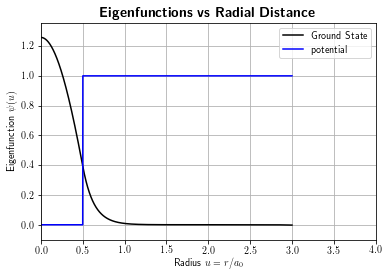

In [10]:
numerical_slv()